# Summary

This notebook aims to add rejection sampling on top of regular Y samples.
We want to reject the samples where branches cross more than once.

In [1]:
from BranchedGP.MBGP.data_generation import ToyBranchedData, GeneExpressionData
from BranchedGP.MBGP.training_helpers import TrainingOutcome, get_training_outcome
from BranchedGP.MBGP.plotting_helpers import plot_detailed_fit, plot_model_snapshot
from BranchedGP.MBGP.assigngp import AssignGP
from BranchedGP.MBGP.VBHelperFunctions import plotBranchModel
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from BranchedGP.MBGP.training_helpers import (
    construct_assigngp_model, 
    SimplePhiConstructor, 
    ScipyOptimiser, 
    ElvijsAmazingOptimiser,
)
import gpflow


data = ToyBranchedData([0.1, 0.3, 0.5], N=100)  # not used; need data to construct a model
m = construct_assigngp_model(
    gene_expression=data,  
    phi_constructor=SimplePhiConstructor(data, prior_confidence=0.65),
    initial_branching_points=[0.5]*data.num_genes,
)
# assign reasonable initial values for the BPs
m.kernel.Bv.assign(np.array([0.1, 0.3, 0.5]))
m.likelihood

Metal device set to: Apple M1


name,class,transform,prior,trainable,shape,dtype,value
Gaussian.variance,Parameter,Softplus + Shift,,True,(),float64,1


In [3]:
from BranchedGP.MBGP.VBHelperFunctions import GetFunctionIndexListGeneral

x_new = np.linspace(0, 1, 50)
x_expanded, indices, _ = GetFunctionIndexListGeneral(x_new)

samples = m.sample_prior(x_expanded, num_samples=10)
print(samples.shape)
print(x_expanded.shape)

(10, 150, 3)
(150, 2)


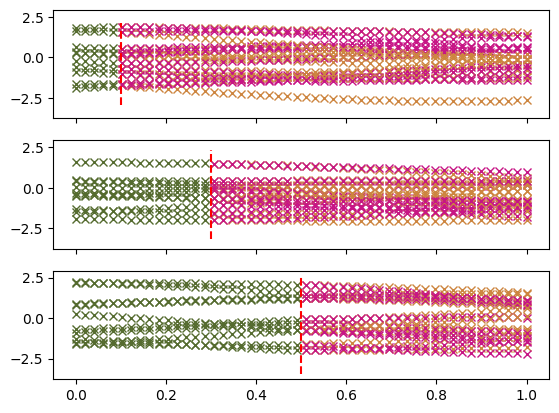

In [4]:
from BranchedGP.MBGP.plotting_helpers import plot_samples

plot_samples(x_expanded, samples, m.BranchingPoints)
plt.show()

We want a function that rejects samples if any of the genes
have the branches crossing after the initial branching point.

In [5]:
def filter_single_crossing(samples: np.ndarray) -> np.ndarray:
    """
    :param samples: [S, 3*N, D] where S is the number of samples, 
                    3*N is the number of points in x_expanded and D is the number of genes.
    :return: filtered samples [S', 3*N, D] where 0 <= S' <= S. Samples are rejected if
             the branches meet more than once.
    """
    S, N3, D = samples.shape
    stepsize = 3.0/N3  # 1/N is the spacing between x
    tol = 3 * stepsize
    
    samples_to_keep = []
    for s in range(S):
        genes_with_good_samples = []
        
        for d in range(D):
            f, g, h = samples[s, 0::3, d], samples[s, 1::3, d], samples[s, 2::3, d]
            # We now look at the sign of (g - h). 
            # If it changes more than once, then we know the branches cross more than once.
            
            g_above_h = (g - h) > 0
            # xor with a shifted version of itself to catch changes in sign
            crossings = np.logical_xor(g_above_h[1:], g_above_h[:-1]).sum()
            
            #intersections_gh = np.where(np.abs(g - h) < tol)
            #intersections = set(intersections_gh[0])
            
            if crossings > 1:
                print("Discarding sample")
                sample = samples[s, :, :]
                sample = np.expand_dims(sample, axis=0)
                plot_samples(x_expanded, sample, m.BranchingPoints)
                continue
            elif crossings == 0:
                raise Exception("Something has gone terribly wrong!")
            else:
                genes_with_good_samples.append(s)
        
        if len(genes_with_good_samples) == D:
            samples_to_keep.append(s)
    
    return samples[samples_to_keep, :, :]

Discarding sample
Discarding sample
Discarding sample
Discarding sample
Discarding sample
Discarding sample
Discarding sample
Discarding sample


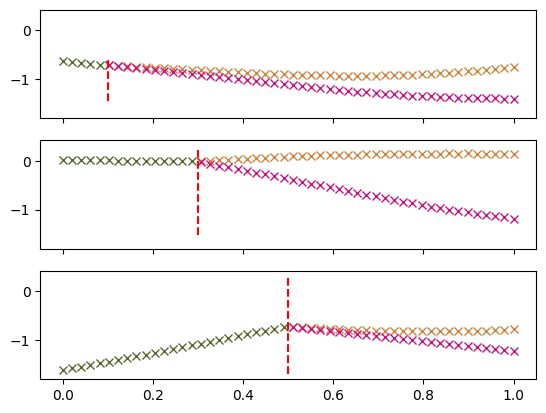

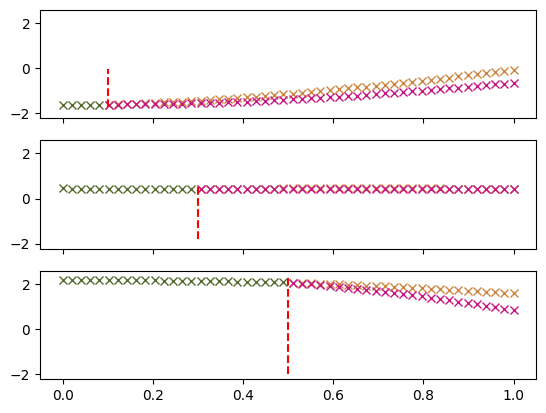

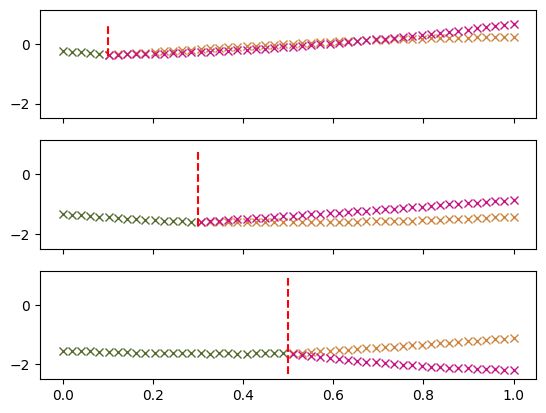

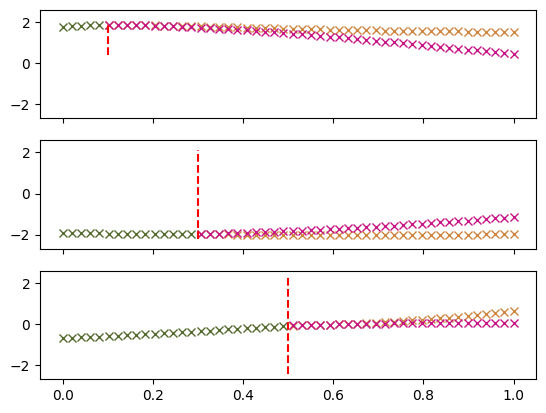

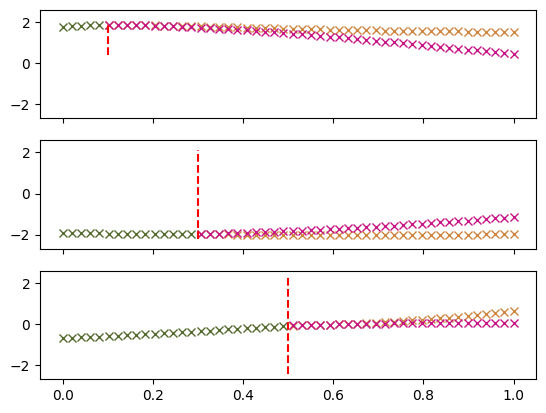

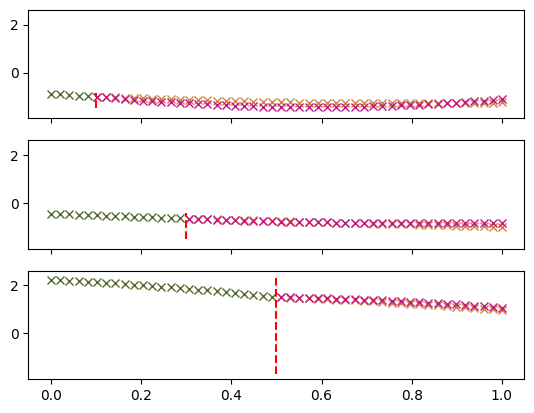

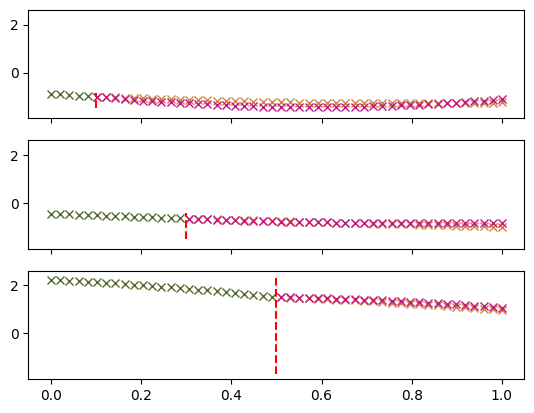

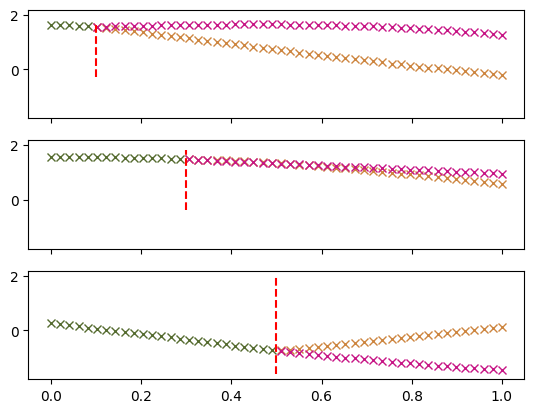

In [6]:
filtered = filter_single_crossing(samples)

In [7]:
filtered

array([[[ 0.24634648,  0.39200365,  0.81094157],
        [ 0.35235397,  0.31440277,  1.22413046],
        [ 0.15617986,  0.46003097,  0.60134503],
        ...,
        [-0.03647182, -0.48453201,  1.06791137],
        [-0.44476933,  0.30702215,  0.76515737],
        [ 1.30329425,  0.15484842,  1.0953496 ]],

       [[ 0.6081923 , -0.50146302, -1.27530156],
        [ 0.51317203, -0.03631038, -1.85786113],
        [ 0.45830077,  0.14186501, -2.08834774],
        ...,
        [ 0.11039856,  1.1841987 , -2.46538406],
        [-0.12940176, -0.72185034, -1.80446065],
        [ 0.19489255, -0.86898965, -1.38025738]],

       [[-1.86883379, -1.52843909,  0.89262574],
        [-1.52386878, -1.531383  ,  0.46437009],
        [-1.81185761, -1.10240144,  0.64607845],
        ...,
        [ 0.21432266,  0.19356751,  1.28944997],
        [-2.64849846, -0.21406507,  1.5127201 ],
        [-0.47102157, -1.28641713,  0.88641656]],

       [[ 0.29380085, -0.3010628 , -0.89010689],
        [ 0.20634731, -0

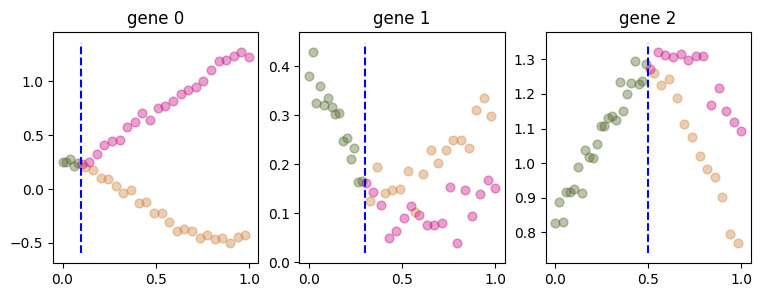

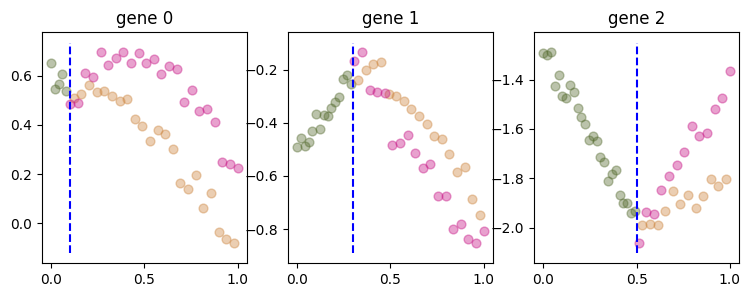

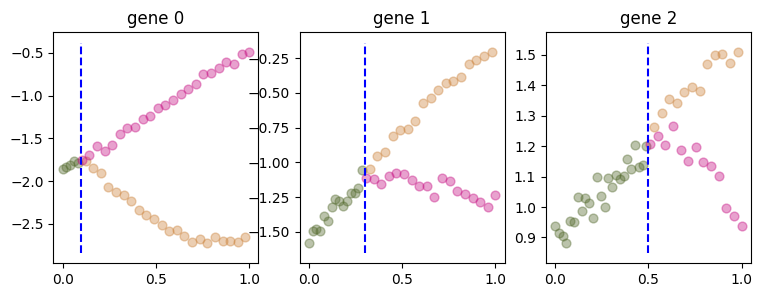

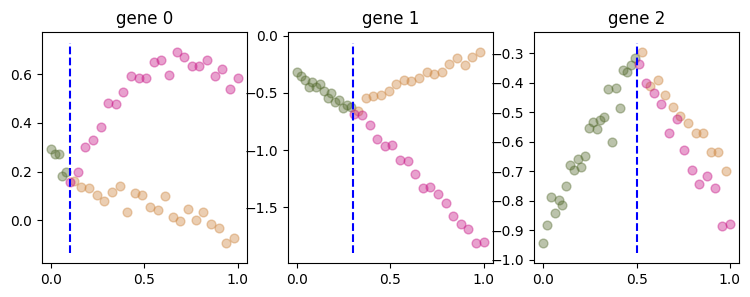

In [8]:
from BranchedGP.MBGP.sampling_helpers import convert_latent_samples_to_branched_data


for sample in filtered:
    branched_data = convert_latent_samples_to_branched_data(
        sample,
        x_expanded=x_expanded,
        branching_points=m.BranchingPoints,
        noise=0.001,
    )
    branched_data.plot()

In [9]:
from typing import Sequence


def get_synthetic_noisy_branched_data(
        model: AssignGP, 
        num_samples: int, 
        x_pts: int = 50,
) -> Sequence[GeneExpressionData]:
    x_new = np.linspace(0, 1, x_pts)
    x_expanded, indices, _ = GetFunctionIndexListGeneral(x_new)

    num_samples_in_a_batch = 10 
    
    branched_data_list = []
    while len(branched_data_list) < num_samples:
        samples = m.sample_prior(x_expanded, num_samples=num_samples_in_a_batch)
        valid_samples = filter_single_crossing(samples)
        
        for sample in valid_samples:
            branched_data = convert_latent_samples_to_branched_data(
                sample,
                x_expanded=x_expanded,
                branching_points=model.BranchingPoints,
                noise=model.likelihood.variance.numpy(),
            )
            branched_data_list.append(branched_data)
        
    return branched_data_list[:num_samples]

Discarding sample
Discarding sample
Discarding sample
Discarding sample
Discarding sample
Discarding sample
Discarding sample
Discarding sample
Discarding sample
Discarding sample
Discarding sample
Discarding sample
Discarding sample
Discarding sample
Discarding sample
Discarding sample
Discarding sample
Discarding sample
Discarding sample
Discarding sample
Discarding sample
Discarding sample


/Users/elvijssarkans/dev/BranchedGP/BranchedGP/MBGP/plotting_helpers.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axa = plt.subplots(num_outputs, 1, sharex=True, sharey=True)


Discarding sample
Discarding sample
Discarding sample
Discarding sample
Discarding sample
Discarding sample
Discarding sample
Discarding sample
Discarding sample
Discarding sample


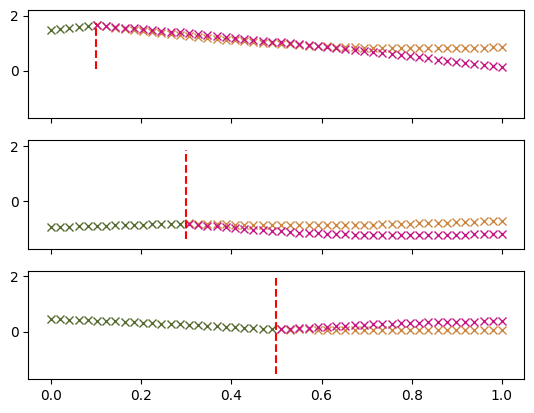

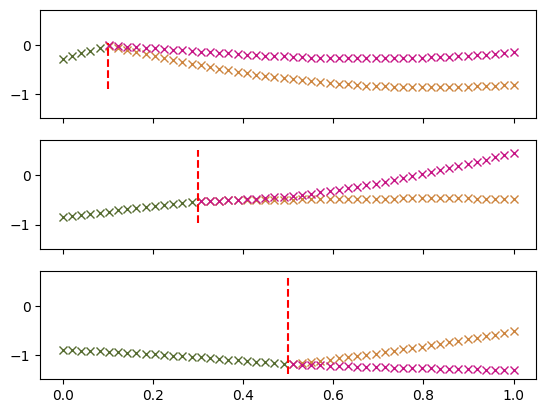

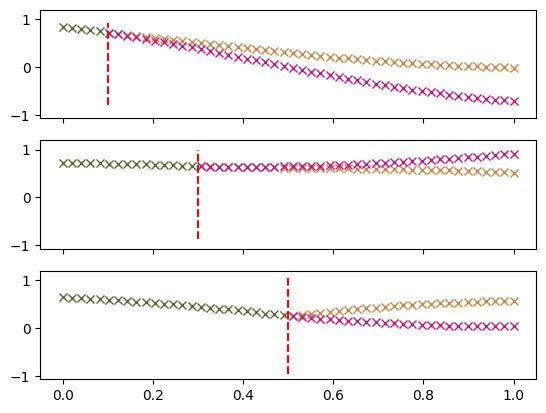

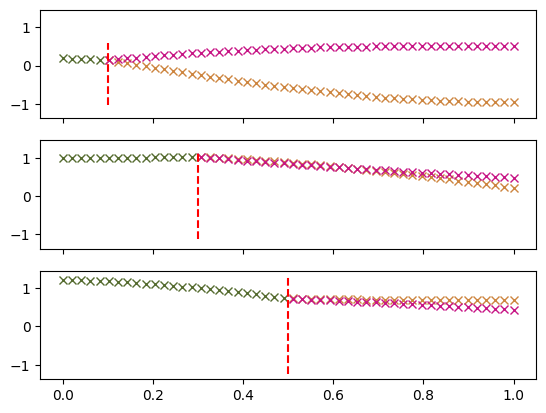

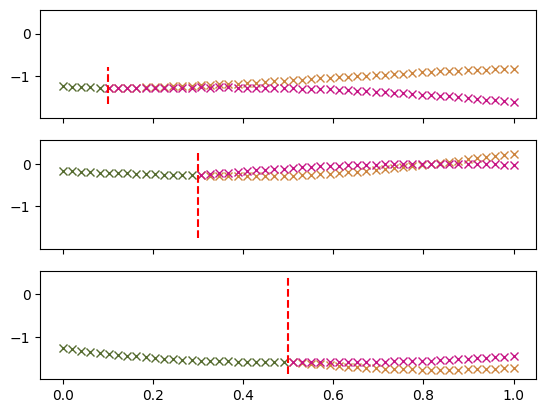

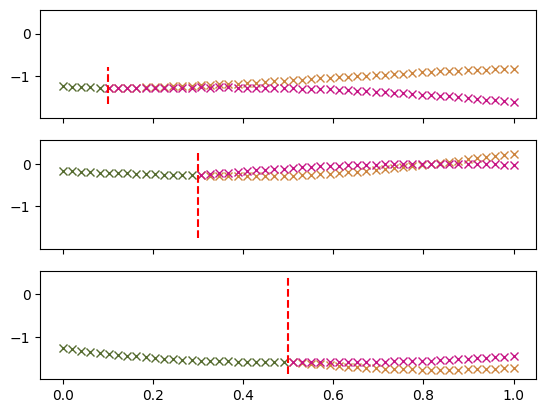

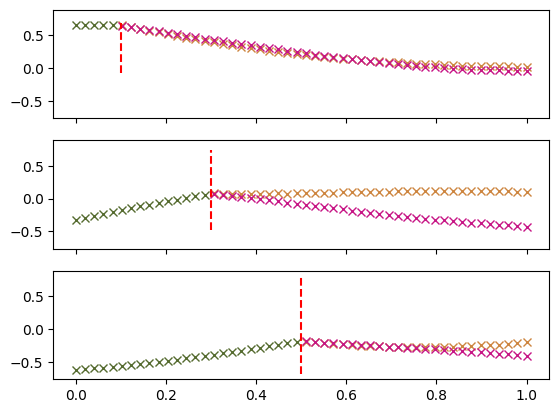

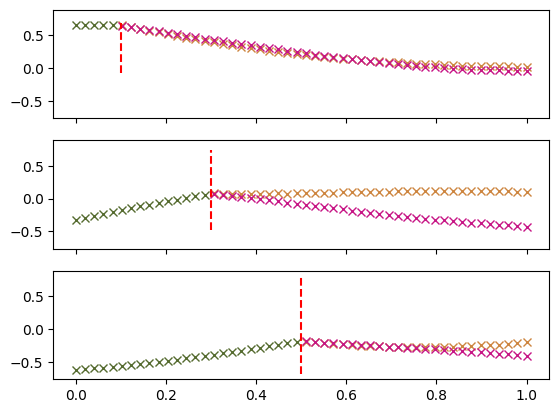

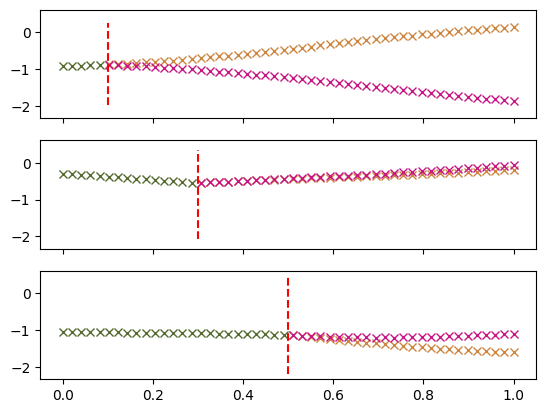

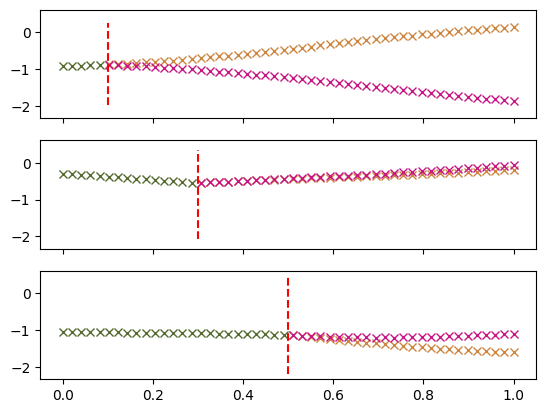

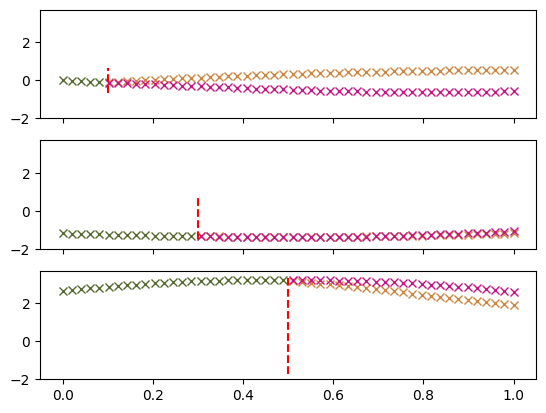

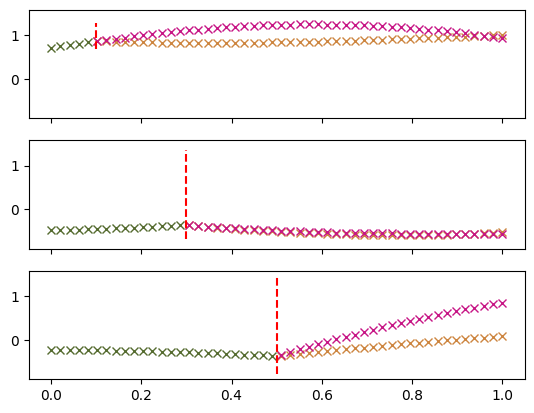

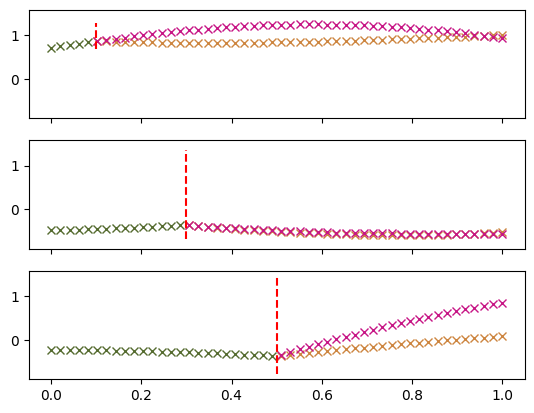

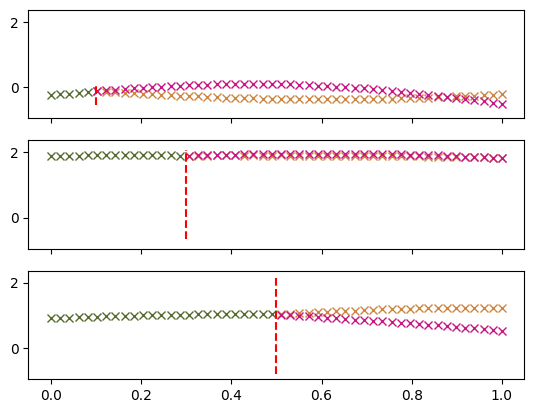

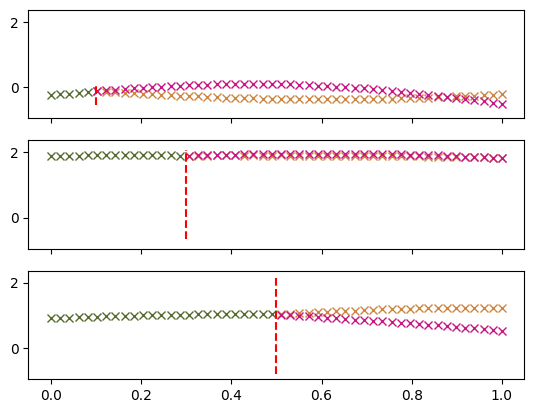

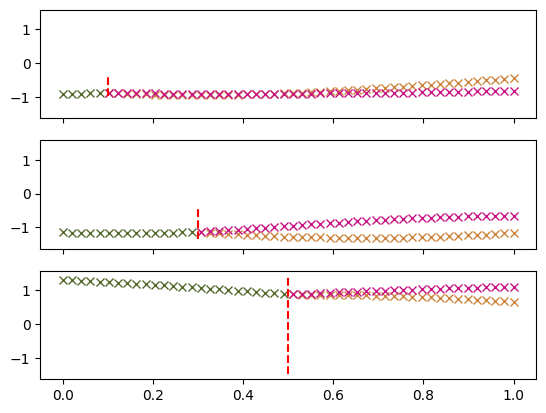

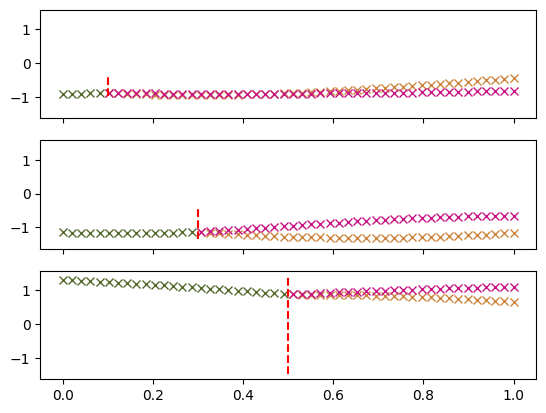

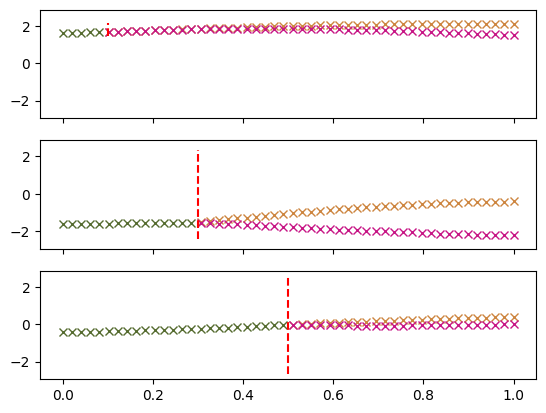

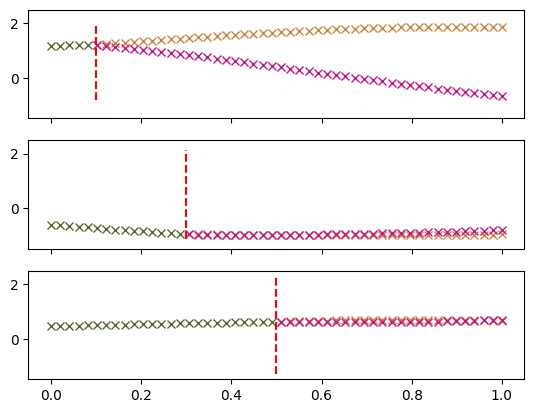

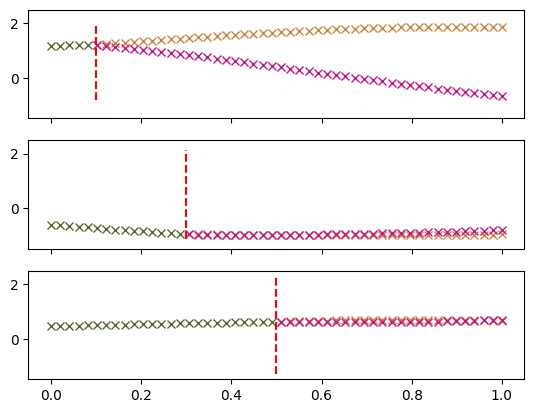

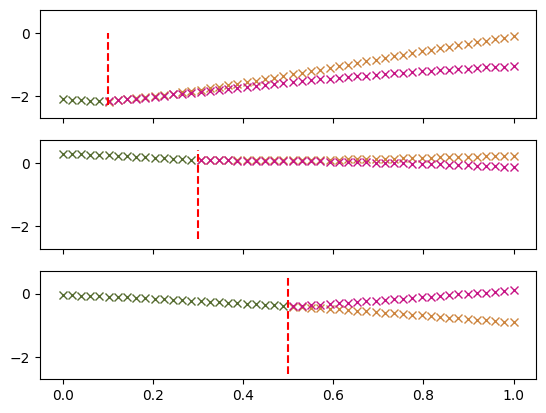

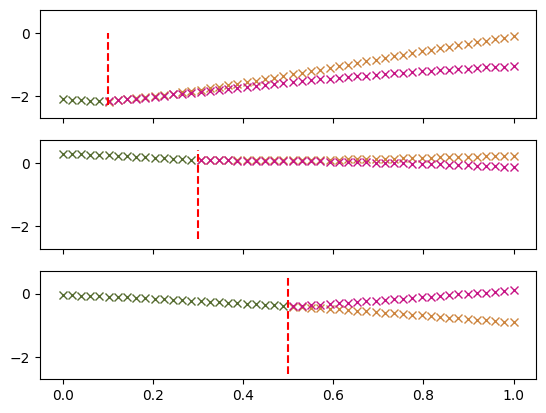

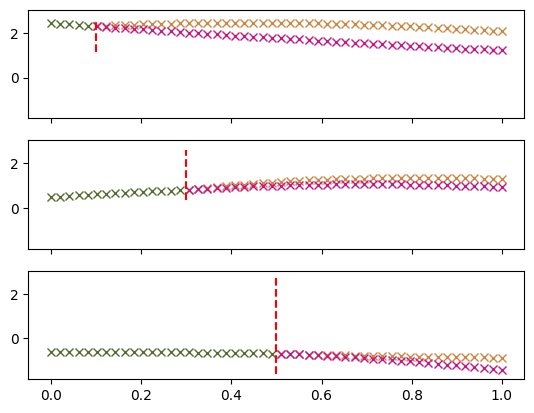

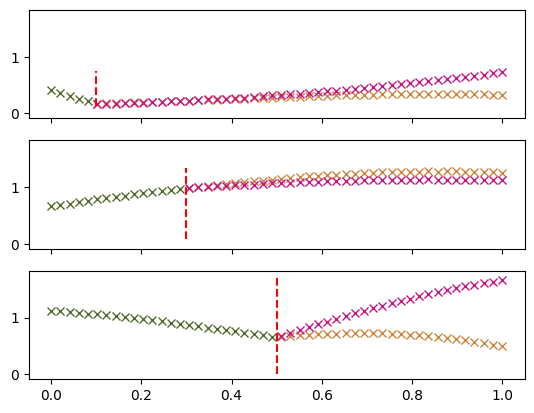

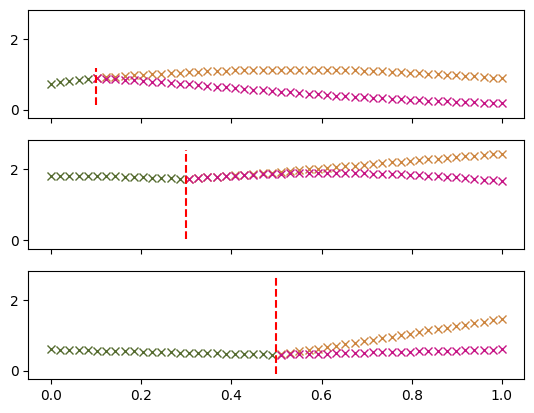

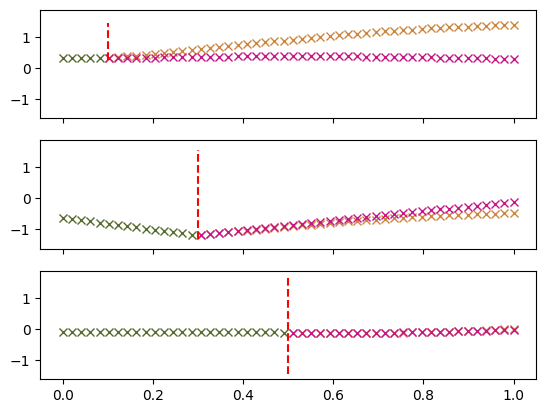

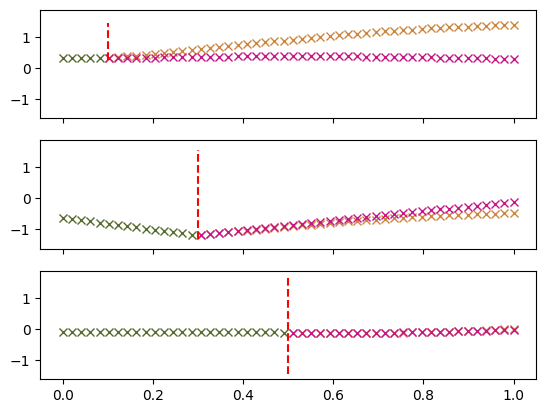

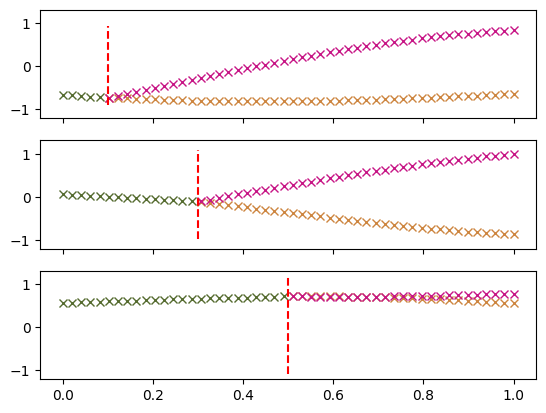

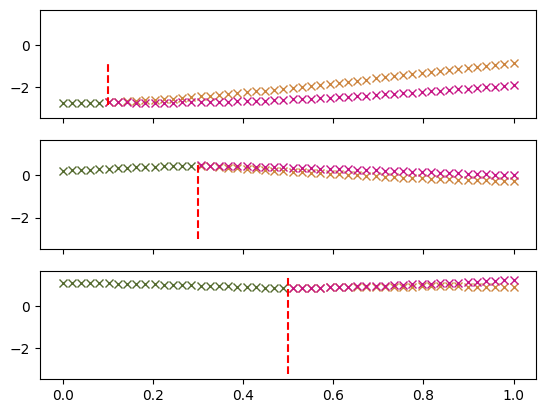

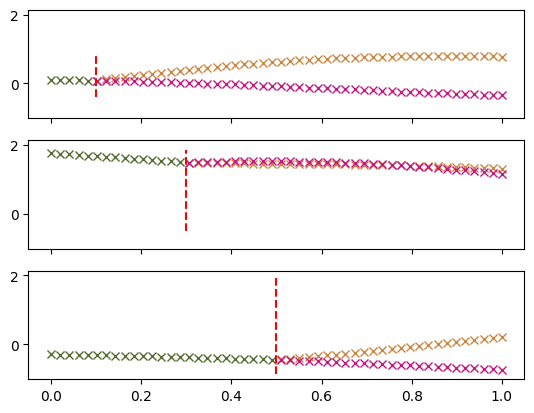

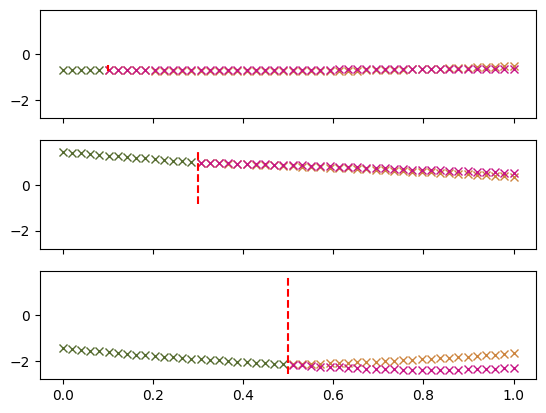

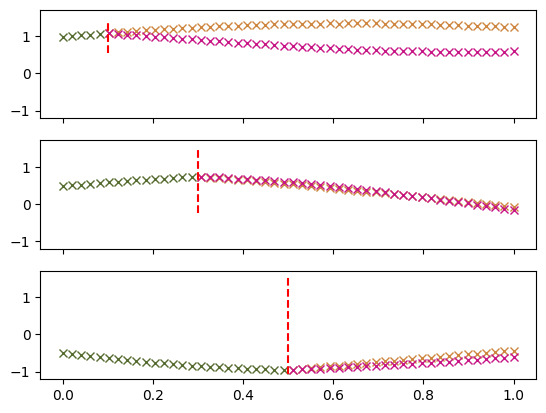

In [10]:
m.likelihood.variance.assign(1e-2)
bds = get_synthetic_noisy_branched_data(model=m, num_samples=20)

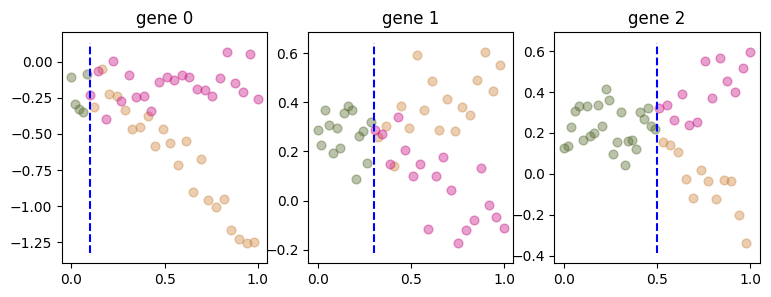

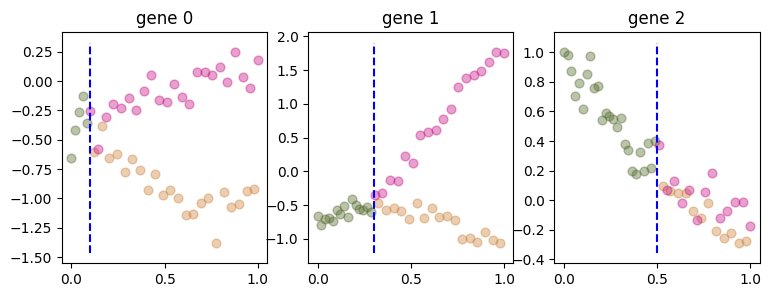

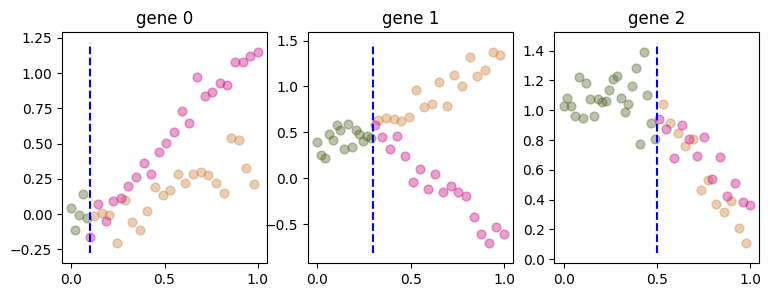

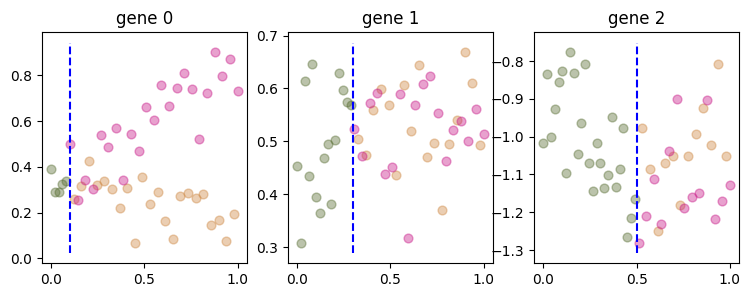

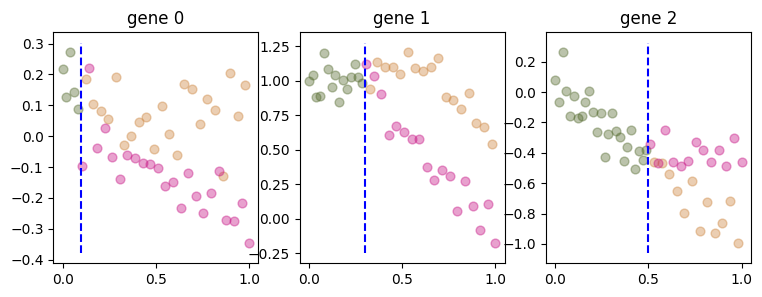

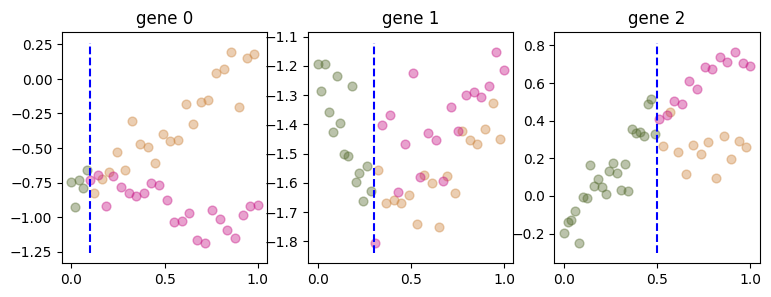

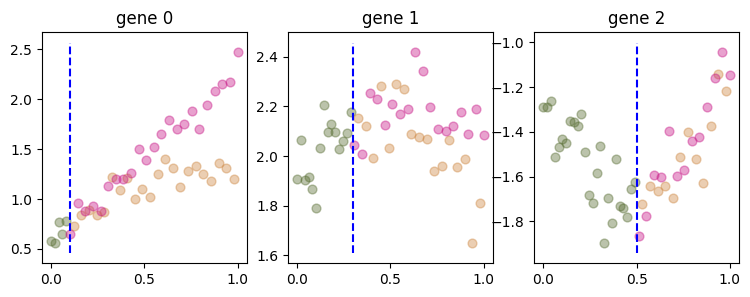

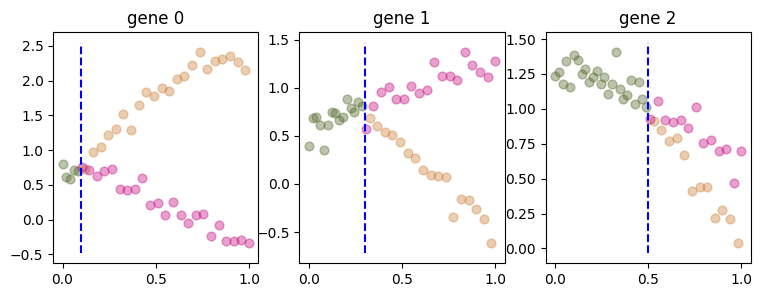

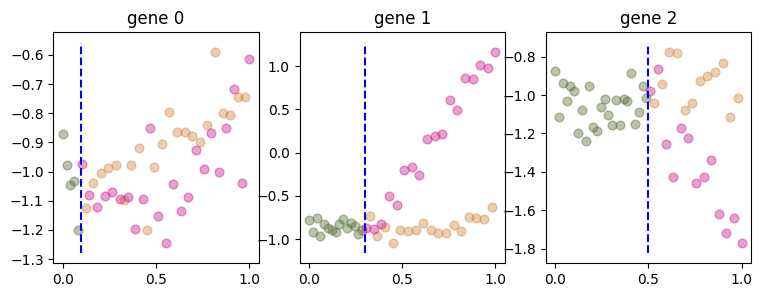

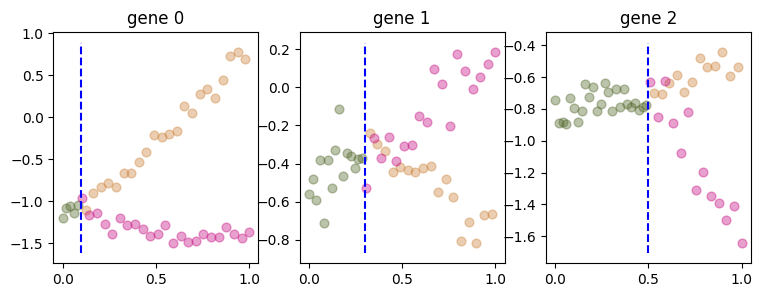

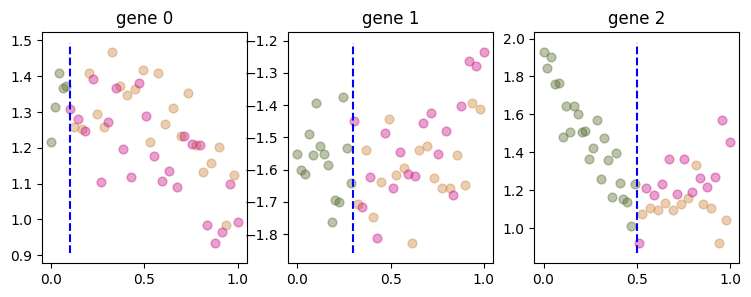

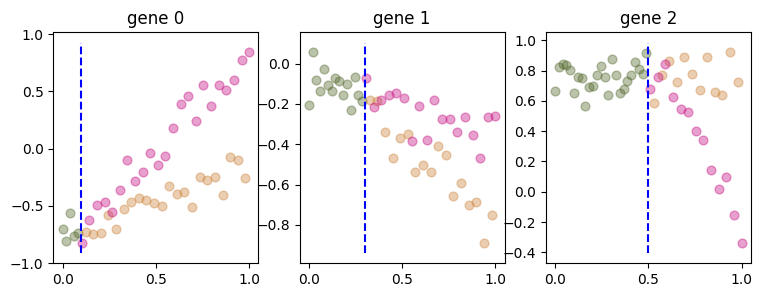

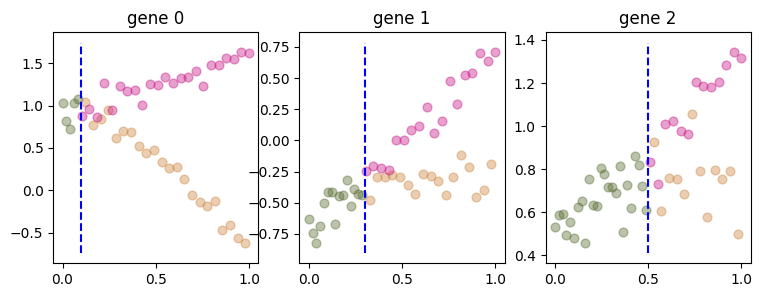

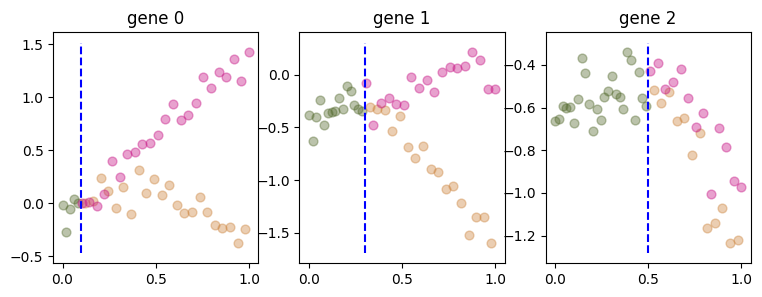

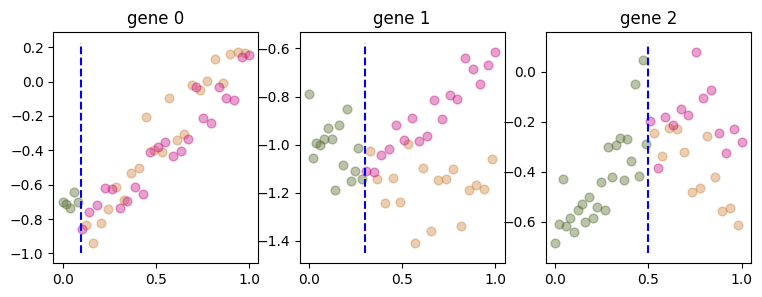

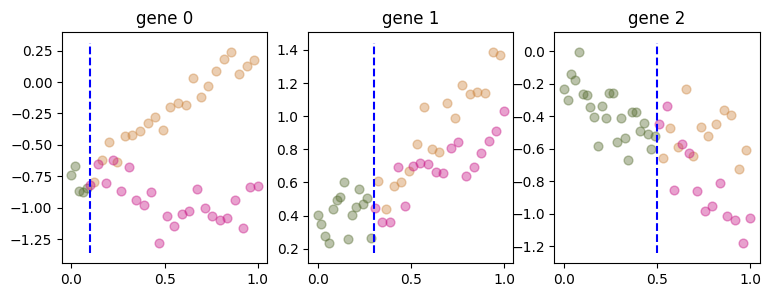

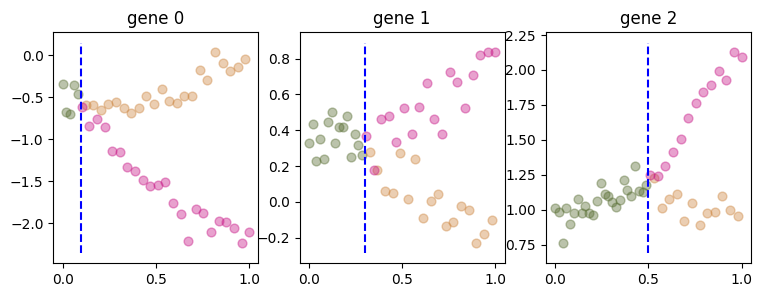

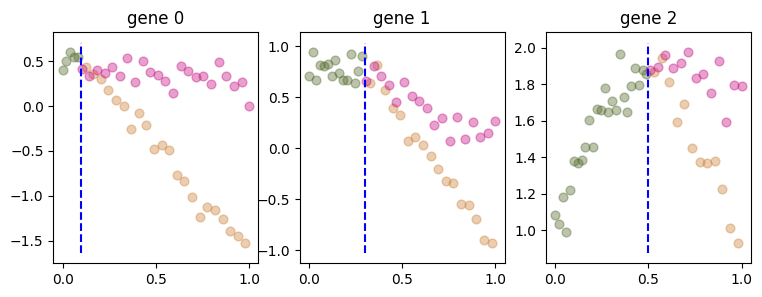

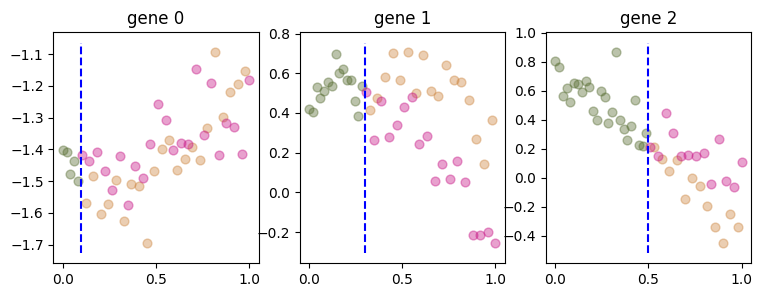

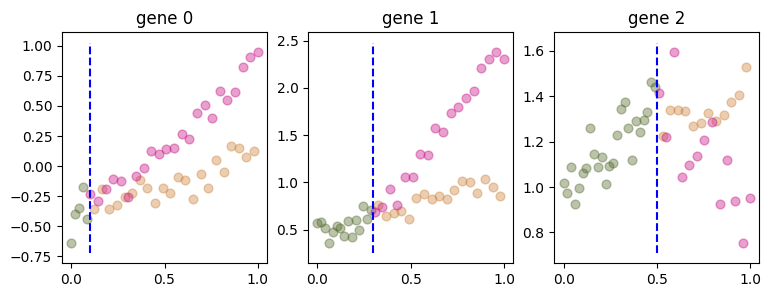

In [11]:
for bd in bds:
    bd.plot()